In [ ]:
!pip install datasets

In [ ]:
pip install pandas

In [ ]:
from datasets import load_dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train-00000-of-00001.parquet:   0%|          | 0.00/324k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/40.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6217 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/777 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6217
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 777
    })
})


In [ ]:
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

# Convert the dataset to a list of dictionaries so train_test_split can be applied
train_data = dataset['train']

# Convert the dataset to a list of dicts (this step should be done carefully)
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split the train data into 90% for training and 10% for testing
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Clean function to preserve emojis and emoticons
def clean_text(text):
    # Remove unwanted characters but keep emojis and emoticons
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Keep only letters, numbers, whitespaces, and emojis
    text = re.sub(r'[^a-zA-Z0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', '', text)
    text = text.strip()
    return text

# Apply the cleaning function to the train, test, and validation datasets
train_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in train_data_split]
test_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in test_data_split]
dataset['validation'] = [{'text': clean_text(item['text']), 'label': item['label']} for item in dataset['validation']]

# Check the cleaned data
print(train_data_split[1])
print(test_data_split[0])
print(dataset['validation'][0])

{'text': 'Haha  nija', 'label': 0}
{'text': '', 'label': 0}
{'text': '100 days pakka', 'label': 0}


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

# Extract train data
train_data = dataset['train']

# Convert to a list of dictionaries for train_test_split
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split train data into 90% train and 10% test
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Convert lists of dictionaries to pandas DataFrames
df_train = pd.DataFrame(train_data_split)
df_test = pd.DataFrame(test_data_split)
df_val = pd.DataFrame([{'text': item['text'], 'label': item['label']} for item in dataset['validation']])

# Ensure the DataFrames contain the required columns
required_columns = ['text', 'label']
for df_name, df in zip(['df_train', 'df_test', 'df_val'], [df_train, df_test, df_val]):
    if not all(col in df.columns for col in required_columns):
        raise KeyError(f"{df_name} must contain the columns {required_columns}.")

# Function to extract emojis from the text
def extract_emojis(text):
    emoji_pattern = re.compile(
        r'[\U0001F600-\U0001F64F'  # emoticons
        r'\U0001F300-\U0001F5FF'  # symbols & pictographs
        r'\U0001F680-\U0001F6FF'  # transport & map symbols
        r'\U0001F700-\U0001F77F'  # alchemical symbols
        r'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        r'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        r'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        r'\U0001FA00-\U0001FA6F'  # Chess Symbols
        r'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        r'\U00002702-\U000027B0'  # Dingbats
        r'\U000024C2-\U0001F251'  # Enclosed characters
        r']+', flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return ''.join(emojis)

# Function to separate emojis and clean text
def separate_emojis(text):
    emojis = extract_emojis(text)
    # Remove emojis and keep only cleaned text
    text_without_emojis = re.sub(r'[^\w\s,\.!?]', '', text)
    return text_without_emojis.strip(), emojis

# Apply the cleaning and emoji extraction function
df_train['cleaned_text'], df_train['emojis'] = zip(*df_train['text'].map(separate_emojis))
df_test['cleaned_text'], df_test['emojis'] = zip(*df_test['text'].map(separate_emojis))
df_val['cleaned_text'], df_val['emojis'] = zip(*df_val['text'].map(separate_emojis))

# Create separate DataFrames for cleaned text and emojis with labels
df_cleaned_text_train = df_train[['cleaned_text', 'label']].copy()
df_emojis_train = df_train[['emojis', 'label']].copy()

df_cleaned_text_test = df_test[['cleaned_text', 'label']].copy()
df_emojis_test = df_test[['emojis', 'label']].copy()

df_cleaned_text_val = df_val[['cleaned_text', 'label']].copy()
df_emojis_val = df_val[['emojis', 'label']].copy()

# Display sample data
print("Cleaned Text Train Data:")
print(df_cleaned_text_train.head())

print("\nEmojis Train Data:")
print(df_emojis_train.head())

print("\nCleaned Text Test Data:")
print(df_cleaned_text_test.head())

print("\nEmojis Test Data:")
print(df_emojis_test.head())

print("\nCleaned Text Validation Data:")
print(df_cleaned_text_val.head())

print("\nEmojis Validation Data:")
print(df_emojis_val.head())

Cleaned Text Train Data:
                       cleaned_text  label
0                          Hands up      0
1                        Haha  nija      0
2                     1 in trending      5
3   Movie hindi me kb tk aa ne ka h      5
4  Edu charitre srustisuva avatraaa      0

Emojis Train Data:
  emojis  label
0             0
1             0
2             5
3             5
4             0

Cleaned Text Test Data:
                                        cleaned_text  label
0  ವವ ಸಪರ ಅನಲಸಸನಮಮ ದಶ ಓಳಳದ...ಮತ ಜಸತ  ಕಲಸ ಕಮಮ........      0
1  Yalla kannadigarugu ansthithu bere bashe movie...      0
2                   Sir make vidieo on drone prathap      5
3                          Vivek G side ge hogro nim      3
4   ಈ ಯಗದ ಶಕರ ನಗ ಗರ ನನ  all the best from DBOSS fans      0

Emojis Test Data:
  emojis  label
0             0
1             0
2             5
3             3
4             0

Cleaned Text Validation Data:
                                        cleaned_text  label
0         

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load a pre-trained model and tokenizer
model_name = "bert-base-uncased"  # Replace with a model fine-tuned for emojis if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings for emojis
def get_emoji_embedding(emojis, tokenizer, model):
    if not emojis:  # No emojis provided
        return torch.zeros(768)  # Assuming the model outputs 768-dimensional embeddings
    inputs = tokenizer(emojis, return_tensors="pt", truncation=True, max_length=10)
    outputs = model(**inputs)
    # Use the mean of the last hidden state as the embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.detach().numpy()

# Apply to your DataFrame
df_emojis_train['emoji_embeddings'] = df_emojis_train['emojis'].map(
    lambda x: get_emoji_embedding(x, tokenizer, model)
)

# Display sample embeddings
print(df_emojis_train[['emojis', 'emoji_embeddings']].head(15))

   emojis                                   emoji_embeddings
0          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
6          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
7          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
8          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
10         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
11         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
12         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
13         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
14         [tensor(0.), tensor(0.), tensor(0.), tensor(0....


In [ ]:
print(df_emojis_train[['emojis', 'emoji_embeddings']].head(75))

   emojis                                   emoji_embeddings
0          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
..    ...                                                ...
70         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
71         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
72         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
73  🤣🤣🤣🤣🤣  [-0.40278354, 0.14599495, -0.37918404, -0.2779...
74         [tensor(0.), tensor(0.), tensor(0.), tensor(0....

[75 rows x 2 columns]


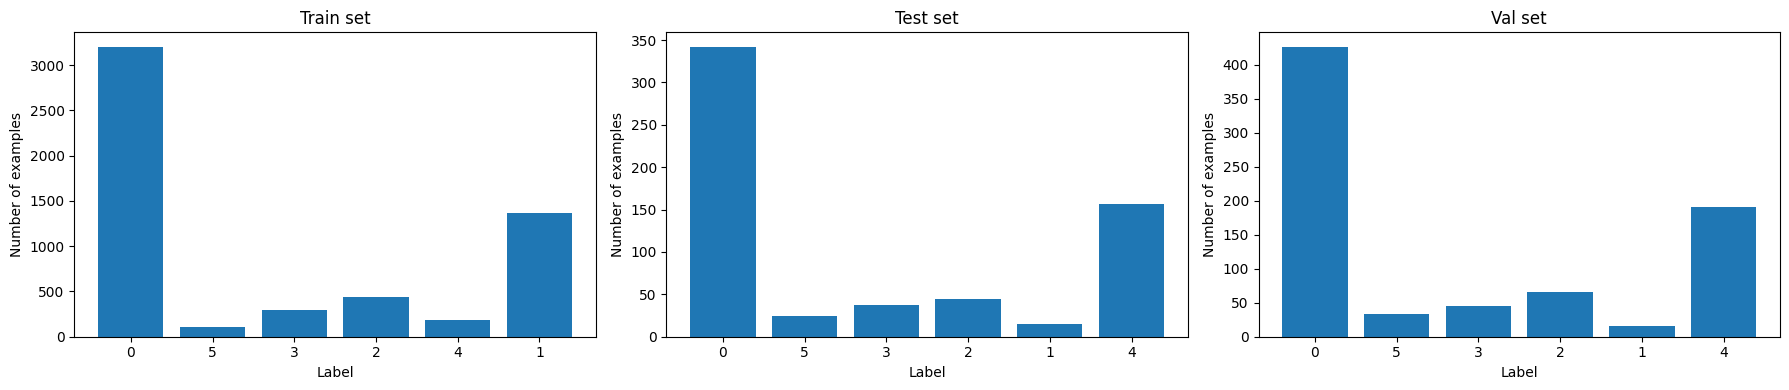

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting the distribution of labels in Train, Test, and Validation datasets
fig = plt.figure(figsize=(18, 4))
titles = ['Train set', 'Test set', 'Val set']

for i, dataf in enumerate([df_train, df_test, df_val]):
    ax = fig.add_subplot(1, 3, i+1)
    Y, labels = pd.factorize(dataf['label'])  # Ensure 'label' column is used
    ax.bar(labels, height=pd.Series(Y).value_counts())  # Bar plot for label count
    ax.set_xticks(ticks=range(len(labels)))  # Position the x-ticks
    ax.set_xticklabels(labels, fontsize=10)  # Set x-tick labels with font size
    ax.set_xlabel('Label')  # X-axis label
    ax.set_ylabel('Number of examples')  # Y-axis label
    ax.set_title(titles[i])  # Title for each plot

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Number of samples in Train, Test, and Validation datasets
train_samples = len(df_train)
test_samples = len(df_test)
val_samples = len(df_val)

# Printing the number of samples
print(f"Number of samples in Train set: {train_samples}")
print(f"Number of samples in Test set: {test_samples}")
print(f"Number of samples in Validation set: {val_samples}")


Number of samples in Train set: 5595
Number of samples in Test set: 622
Number of samples in Validation set: 777


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle
from transformers import XLMRobertaTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW  # Use this instead
from torch.optim import SGD

In [ ]:
pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.2
    Uninstalling transformers-4.50.2:
      Successfully uninstalled transformers-4.50.2


In [ ]:
import os

# Set parameters for fine-tuning
L_RATE = 3e-5  # Learning rate
MAX_LEN = 128  # Maximum sequence length (adjust according to your dataset)
NUM_EPOCHS = 3  # Number of epochs for fine-tuning
BATCH_SIZE = 32  # Batch size (can be adjusted based on GPU memory, using 64 if you have sufficient resources)
NUM_CORES = os.cpu_count()  # Number of CPU cores available for data processing
print(NUM_CORES)  # Print number of cores detected

# You can now use these parameters in your fine-tuning script


2


In [ ]:
import torch
from transformers import XLMRobertaForSequenceClassification

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the XLM-RoBERTa model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=6  # Set the number of labels to 6 (or the number of unique labels in your dataset)
)

# Move model to the device
model.to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
from torch.utils.data import Dataset
import torch
from transformers import XLMRobertaTokenizer

# Initialize the tokenizer
rTokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

class CompDataset(Dataset):

    def __init__(self, df):
        self.df_data = df

    def __getitem__(self, index):
        text = self.df_data.loc[index, 'cleaned_text']
        # Tokenization
        encoded_dict = rTokenizer.encode_plus(
                    text,
                    max_length = MAX_LEN,
                    padding='max_length',  # Use padding='max_length' instead of pad_to_max_length
                    truncation=True,  # Ensure that the text is truncated if it exceeds MAX_LEN
                    return_attention_mask=True,
                    return_tensors='pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, 'label'])

        sample = (padded_token_list, att_mask, target)
        return sample

    def __len__(self):
        return len(self.df_data)


In [ ]:
train_dataset = CompDataset(df_cleaned_text_train)  # Pass your cleaned train DataFrame
test_dataset = CompDataset(df_cleaned_text_test)    # Pass your cleaned test DataFrame
validation_dataset = CompDataset(df_cleaned_text_val)  # Pass your validation DataFrame

In [ ]:
print(len(test_dataset))
print(len(train_dataset))
print(len(validation_dataset))

622
5595
777


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def createBaseline(data, name):
    # Initialize the dataset and dataloader
    test_data = CompDataset(data)
    dataloader = torch.utils.data.DataLoader(test_data,
                      batch_size=BATCH_SIZE,
                      shuffle=False,  # No need to shuffle in the validation or test set
                      num_workers=NUM_CORES)

    # Set model to evaluation mode and disable gradient computation
    model.eval()
    torch.set_grad_enabled(False)

    # Initialize lists to store the predictions and true labels
    targets_list = []
    all_preds = []

    # Loop over the dataloader to get batches
    for j, batch in enumerate(dataloader):
        # Move the batch tensors to the device
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Get model predictions
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        preds = outputs[1]  # Get the logits

        # Convert predictions to numpy arrays and store them
        val_preds = preds.detach().cpu().numpy()
        targets_np = b_labels.to('cpu').numpy()
        targets_list.extend(targets_np)

        # Accumulate predictions
        all_preds.append(val_preds)

    # Convert the list of predictions into a single array
    stacked_val_preds = np.vstack(all_preds)

    # Calculate the predicted labels by taking argmax of logits
    y_true = np.array(targets_list)
    y_pred = np.argmax(stacked_val_preds, axis=1)

    # Compute accuracy, precision, recall, and F1 score
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')  # Adding average='weighted' for handling class imbalance

    # Print results
    print(f"{name} test acc: {acc:.4f}")
    print(f"{name} test precision: {precision:.4f}")
    print(f"{name} test recall: {recall:.4f}")
    print(f"{name} test F1: {f1:.4f}")

In [ ]:
createBaseline(df_cleaned_text_test, "kannada")

kannada test acc: 0.5434
kannada test precision: 0.3037
kannada test recall: 0.5434
kannada test F1: 0.3896


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import random
import gc

In [ ]:
print(model.parameters())

<generator object Module.parameters at 0x79f6ed9f4ac0>


In [ ]:
optimizer = AdamW(model.parameters(),
              lr = L_RATE,
              eps = 1e-8
            )

In [ ]:
train_data = CompDataset(df_cleaned_text_train)
val_data = CompDataset(df_cleaned_text_val)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=NUM_CORES)
val_dataloader = torch.utils.data.DataLoader(val_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=NUM_CORES)

In [ ]:
gc.collect()

0

In [ ]:
import torch
import random
import numpy as np
import gc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

seed_val = 101

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []

# Define your number of epochs
NUM_EPOCHS = 5

for epoch in range(0, NUM_EPOCHS):

    print("\n======== Epoch {:} / {:} ========".format(epoch + 1, NUM_EPOCHS))

    stacked_val_labels = []
    targets_list = []

    # Training Phase
    print('Training...')
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss = 0
    gc.collect()

    for i, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
        optimizer.step()  # Update model weights
        gc.collect()

    print('Train loss:', total_train_loss)
    gc.collect()

    # Validation Phase
    print('\nValidation...')
    model.eval()
    torch.set_grad_enabled(False)
    total_val_loss = 0

    for j, batch in enumerate(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_val_loss += loss.item()
        preds = outputs[1]
        val_preds = preds.detach().cpu().numpy()
        targets_np = b_labels.to('cpu').numpy()
        targets_list.extend(targets_np)
        if j == 0:
            stacked_val_preds = val_preds
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        gc.collect()

    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='weighted')
    val_precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    val_recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)

    print('Val loss:', total_val_loss)
    print('Val acc:', val_acc)
    print('Val F1:', val_f1)
    print('Val Precision:', val_precision)
    print('Val Recall:', val_recall)

    gc.collect()

    # Save model weights after each epoch
    torch.save(model.state_dict(), 'model.pt')
    gc.collect()


======== Epoch 1 / 5 ========
Training...
Train loss: 191.39738684892654

Validation...
Val loss: 23.771032452583313
Val acc: 0.6653796653796654
Val F1: 0.5867540709191381
Val Precision: 0.7450296751538987
Val Recall: 0.6653796653796654

======== Epoch 2 / 5 ========
Training...
Train loss: 156.41311591863632

Validation...
Val loss: 22.142173290252686
Val acc: 0.6988416988416989
Val F1: 0.6485838379908317
Val Precision: 0.7303844312631279
Val Recall: 0.6988416988416989

======== Epoch 3 / 5 ========
Training...
Train loss: 141.86844739317894

Validation...
Val loss: 22.050776690244675
Val acc: 0.7027027027027027
Val F1: 0.6556978357295159
Val Precision: 0.7360077939991024
Val Recall: 0.7027027027027027

======== Epoch 4 / 5 ========
Training...
Train loss: 126.07086163759232

Validation...
Val loss: 21.427908062934875
Val acc: 0.7207207207207207
Val F1: 0.6744541446055038
Val Precision: 0.7382724072045281
Val Recall: 0.7207207207207207

======== Epoch 5 / 5 ========
Training...
Train